In [4]:
!pip install qiskit qiskit-aer numpy scipy matplotlib


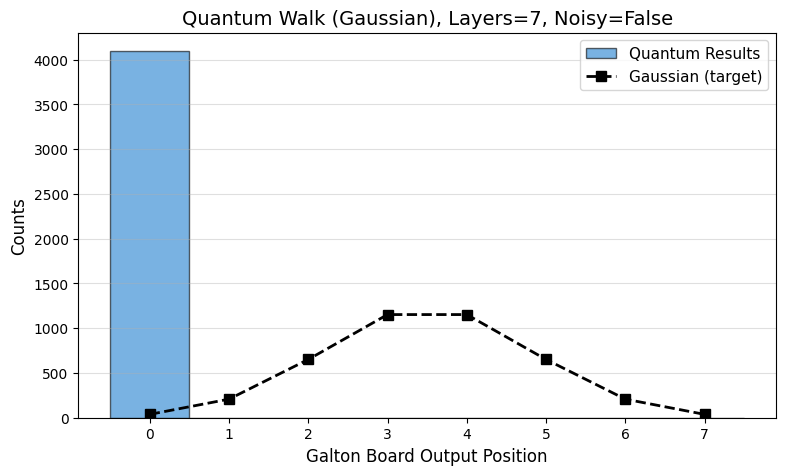

===== Simulation Statistics =====
Distribution: gaussian, Layers: 7, Noisy: False
Quantum mean:      0.000
Quantum variance:  0.000
Target mean:       3.500
Target variance:   1.712
Wasserstein dist.: 0.17967


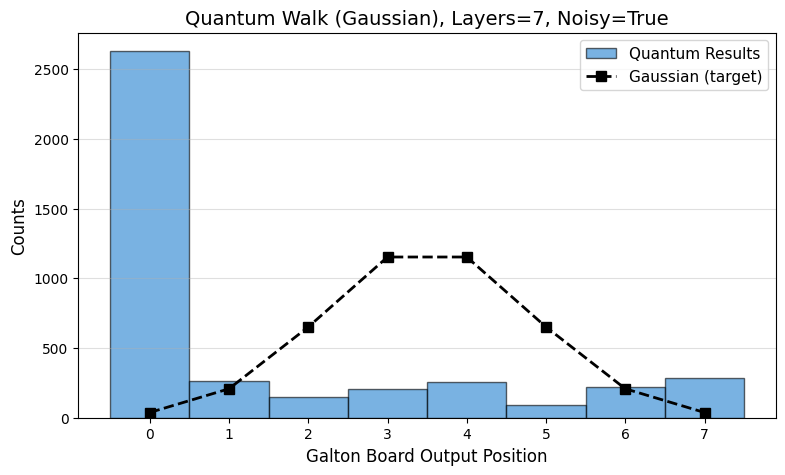

===== Simulation Statistics =====
Distribution: gaussian, Layers: 7, Noisy: True
Quantum mean:      1.458
Quantum variance:  5.435
Target mean:       3.500
Target variance:   1.712
Wasserstein dist.: 0.10104


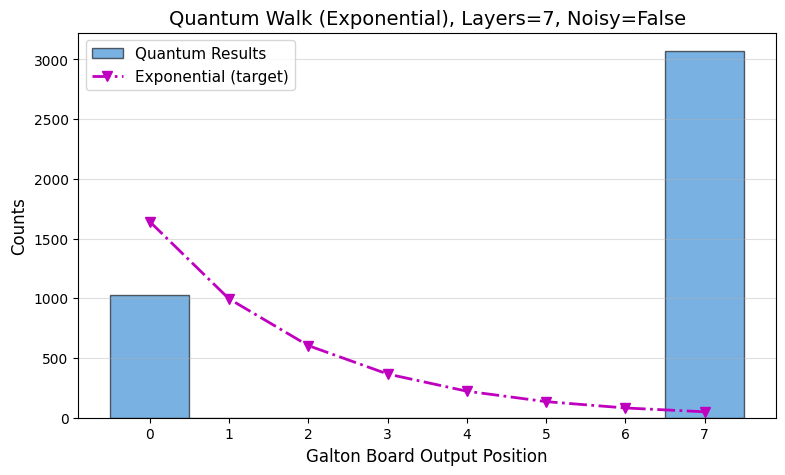

===== Simulation Statistics =====
Distribution: exponential, Layers: 7, Noisy: False
Quantum mean:      5.247
Quantum variance:  9.199
Target mean:       1.392
Target variance:   2.701
Wasserstein dist.: 0.08902


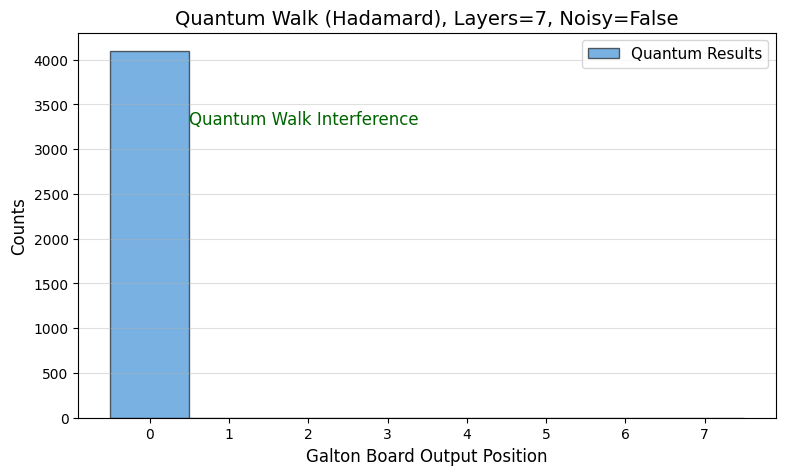

===== Simulation Statistics =====
Distribution: hadamard, Layers: 7, Noisy: False
Quantum mean:      0.000
Quantum variance:  0.000
Target mean:       0.000
Target variance:   0.000
Wasserstein dist.: 0.00000


{'mean_quantum': np.float64(0.0),
 'variance_quantum': np.float64(0.0),
 'mean_target': np.float64(0.0),
 'variance_target': np.float64(0.0),
 'wasserstein_distance': np.float64(0.0)}

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon, wasserstein_distance

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

class QuantumWalkMonteCarlo:
    def __init__(self, num_layers=5, dist_type="gaussian", shots=2000, noisy=False, p1q=0.01, p2q=0.03):
        self.num_layers = num_layers
        self.dist_type = dist_type
        self.shots = shots
        self.noisy = noisy
        self.p1q = p1q
        self.p2q = p2q
        self.pos_qubits = int(np.ceil(np.log2(self.num_layers + 1)))
        self.backend = AerSimulator()
        self.noise_model = self._create_noise_model() if noisy else None

    def _create_noise_model(self):
        noise_model = NoiseModel()
        noise_model.add_all_qubit_quantum_error(depolarizing_error(self.p1q, 1), ['u3', 'u2', 'u1'])
        noise_model.add_all_qubit_quantum_error(depolarizing_error(self.p2q, 2), ['cx'])
        return noise_model

    def _coin_operation(self, qc, coin_qubit):
        if self.dist_type == "gaussian" or self.dist_type == "hadamard":
            qc.h(coin_qubit)
        elif self.dist_type == "exponential":
            qc.ry(np.pi/6, coin_qubit)
        else:
            raise ValueError(f"Unknown distribution type '{self.dist_type}'")

    def _shift_operation(self, qc, coin_qubit):
        for pos in range(self.pos_qubits):
            qc.cx(coin_qubit, pos)

    def create_circuit(self):
        qc = QuantumCircuit(self.pos_qubits + 1, self.pos_qubits)
        coin = self.pos_qubits
        for _ in range(self.num_layers):
            self._coin_operation(qc, coin)
            self._shift_operation(qc, coin)
        qc.measure(range(self.pos_qubits), range(self.pos_qubits))
        return qc

    def run_simulation(self):
        qc = self.create_circuit()
        if self.noisy:
            result = self.backend.run(qc, noise_model=self.noise_model, shots=self.shots).result()
        else:
            result = self.backend.run(qc, shots=self.shots).result()
        counts = result.get_counts()
        positions = []
        for bitstr, count in counts.items():
            pos = int(bitstr.replace(' ',''), 2)
            positions.extend([pos]*count)
        return positions

    def plot_results(self, positions, savefig=None):
        bins = np.arange(-0.5, self.num_layers + 1.5, 1)
        x = np.arange(0, self.num_layers + 1)
        plt.figure(figsize=(9, 5))
        plt.hist(positions, bins=bins, alpha=0.6, label='Quantum Results', color='#2080D0', edgecolor='k')
        if self.dist_type == "gaussian":
            meanT = self.num_layers / 2
            stdevT = np.sqrt(self.num_layers) / 2
            y = norm.pdf(x, meanT, stdevT)
            y_scaled = y / y.sum() * self.shots
            plt.plot(x, y_scaled, 'ks--', label='Gaussian (target)', lw=2, markersize=7)
        elif self.dist_type == "exponential":
            y = expon.pdf(x, scale=2)
            y_scaled = y / y.sum() * self.shots
            plt.plot(x, y_scaled, 'mv-.', label='Exponential (target)', lw=2, markersize=7)
        elif self.dist_type == "hadamard":
            plt.text(0.5, 0.8*self.shots, 'Quantum Walk Interference', color='darkgreen', fontsize=12)
        plt.xlabel('Galton Board Output Position', fontsize=12)
        plt.ylabel('Counts', fontsize=12)
        plt.title(f'Quantum Walk ({self.dist_type.capitalize()}), Layers={self.num_layers}, Noisy={self.noisy}', fontsize=14)
        plt.legend(fontsize=11)
        plt.grid(True, axis='y', alpha=0.4)
        if savefig:
            plt.savefig(savefig, bbox_inches='tight')
        plt.show()

    def get_distribution_stats(self, positions):
        hist, _ = np.histogram(positions, bins=np.arange(-0.5, self.num_layers + 1.5, 1), density=True)
        x = np.arange(0, self.num_layers + 1)
        if self.dist_type == "gaussian":
            target = norm.pdf(x, self.num_layers/2, np.sqrt(self.num_layers)/2)
        elif self.dist_type == "exponential":
            target = expon.pdf(x, scale=2)
        else:
            target = hist
        target = target/target.sum()
        wasserstein = wasserstein_distance(hist, target)
        mean_q = np.mean(positions)
        var_q = np.var(positions)
        mean_t = np.sum(x * target)
        var_t = np.sum((x - mean_t) ** 2 * target)
        return {
            "mean_quantum": mean_q,
            "variance_quantum": var_q,
            "mean_target": mean_t,
            "variance_target": var_t,
            "wasserstein_distance": wasserstein
        }

    def run_all(self, savefig=None, verbose=True):
        positions = self.run_simulation()
        self.plot_results(positions, savefig=savefig)
        stats = self.get_distribution_stats(positions)
        if verbose:
            print("===== Simulation Statistics =====")
            print(f"Distribution: {self.dist_type}, Layers: {self.num_layers}, Noisy: {self.noisy}")
            print(f"Quantum mean:      {stats['mean_quantum']:.3f}")
            print(f"Quantum variance:  {stats['variance_quantum']:.3f}")
            print(f"Target mean:       {stats['mean_target']:.3f}")
            print(f"Target variance:   {stats['variance_target']:.3f}")
            print(f"Wasserstein dist.: {stats['wasserstein_distance']:.5f}")
        return stats

qw1 = QuantumWalkMonteCarlo(num_layers=7, dist_type="gaussian", shots=4096, noisy=False)
qw1.run_all()

qw2 = QuantumWalkMonteCarlo(num_layers=7, dist_type="gaussian", shots=4096, noisy=True)
qw2.run_all()

qw3 = QuantumWalkMonteCarlo(num_layers=7, dist_type="exponential", shots=4096, noisy=False)
qw3.run_all()

qw4 = QuantumWalkMonteCarlo(num_layers=7, dist_type="hadamard", shots=4096, noisy=False)
qw4.run_all()
